# Analysis and comparison of different spectral clustering implementations
<pre>
Source publication for dataset: 
https://www.nature.com/articles/s41467-018-02866-0
TODO
References:
</pre>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hypernetx as hnx
import model
import utils

# Initialization

In [2]:
cell_count = 456
gene_count = 100
infile_dir = "./../data/TEsmESC/"

m = model.HyperGraph(n_cells=cell_count, n_genes=gene_count, infile_dir=infile_dir)


# Graph Construction

In [3]:
m.construct_graph(0.85)
HG = m.HG 
m.prune_graph()

# Visualizing TE scores across cells (over time)

In [4]:
# heat_fig = sn.heatmap(PWscores[0, :, :], square=True)
    # as_file = heat_fig.get_figure()
    # path = "./../out/cell{i}.png".format(i = i + 1)
    # as_file.savefig(path)
    # ax.tick_params(left=False, bottom=False)

# Hypergraph Visualization

In [5]:
# plt.figure(dpi=360)
# plt.savefig("./hgraphsmall")
# utils.visualize_hyperedge_set(m)

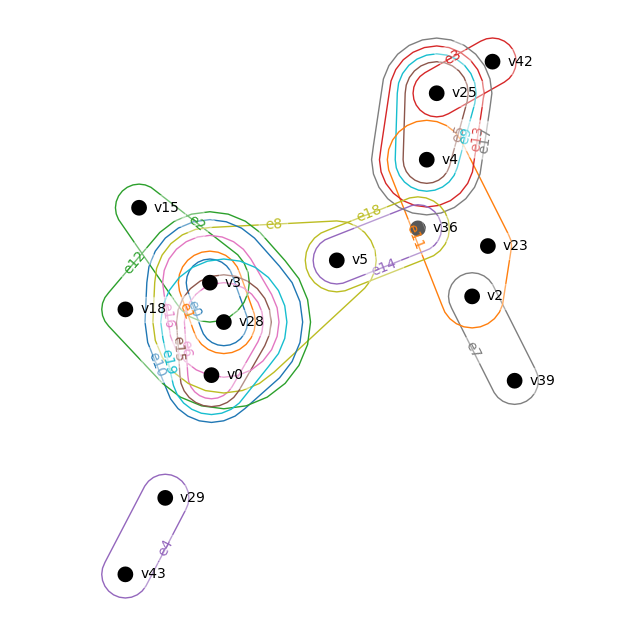

In [6]:
H_test = hnx.classes.Hypergraph.from_numpy_array(M = m.H[:, 60:80])
hnx.drawing.rubber_band.draw(H_test)

# Forming the graph Laplacian

In [7]:
m.set_graph_Laplacian()

# From *On Spectral Clustering: Analysis and an algorithm*

From L-normal:
1. Find k **largest** orthogonal eigen*vectors* (orthogonal to avoid vecs of repeated eigen*values*) of L
2. Make a matrix of 'em, n_genes x k = X
3. Y = Normalize each row of X to have unit length
4. Treat each row of Y as a point in R<sup>k</sup>, cluster into k-clusters via kmeans
5. Assign rows i (you can just use the gene labels vector) to cluster j iff row i in Y was assigned to cluster j 



In [8]:
sorted_eigvals, sorted_eigvecs = m.get_sorted_eigens()

# Visualizing Eigenvalues for Hyperparameter Selection

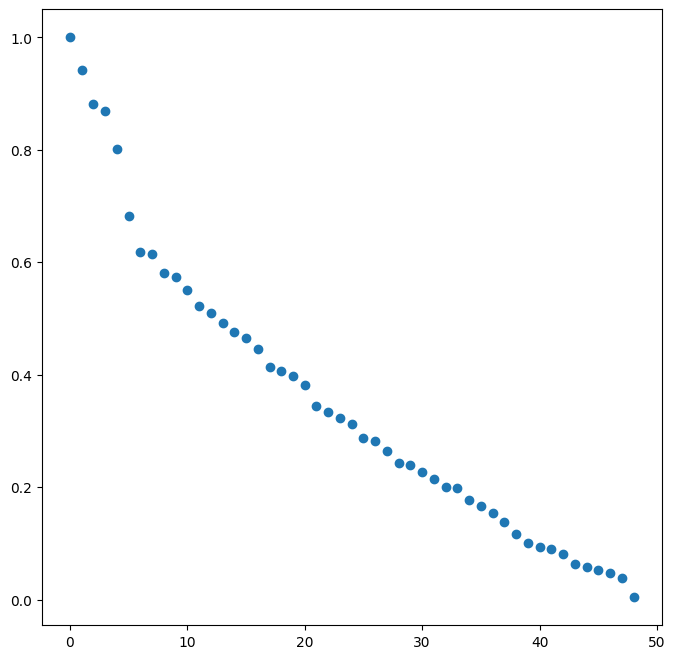

In [9]:
x = np.arange(m.n_genes)
plt.scatter(x, sorted_eigvals)

# Perform the clustering to determine the pathways

In [10]:
clusters = utils.get_clusters(5, sorted_eigvecs, m.gene_labels, 3)

In [11]:
for c in clusters:
    print(c)
    print("\n")

['SOX2' 'EPAS1' 'FOXQ1' 'KLF2' 'GATA4' 'SOX17' 'POU5F1' 'DNMT3A' 'TFCP2L1'
 'TCF15' 'ELF3' 'HMGA1' 'CREB3L2' 'FOXH1' 'NFXL1' 'SOX7' 'RBPJ' 'KDM5B'
 'BHLHE40' 'RUNX1' 'SNAI1' 'BMP2' 'CREB3' 'SIX1' 'ZBTB10' 'RERE' 'MSC'
 'TRP53' 'GATA6' 'HOPX' 'HNF1B' 'KLF3' 'DNMT3L' 'TBX3' 'FOXD3' 'MYBL2'
 'TEAD4' 'NFIL3' 'ID3' 'PURB' 'PHB' 'ERF' 'HNRNPK' 'ELF2' 'BMYC' 'TFEB'
 'SALL4']




# Analysis with hnx package

In [12]:
# H_uw = utils.get_unweighted_graph(m.H)
# hnx.drawing.rubber_band.draw(H_uw)

In [13]:
Lap, index = hnx.algorithms.laplacians_clustering.norm_lap(HG, weights=True)
Lap = Lap.toarray()

In [14]:
# Lap.shape[0] == m.n_genes

In [15]:
evals, evecs = np.linalg.eig(Lap)

# sort eigenvals, then sort eigenvecs by the eigenvals
sorted_i = np.flip(np.argsort(evals))
sorted_evals = evals[sorted_i] # sort the vals
sorted_evecs = evecs[:,sorted_i] # sorts the columns

# Sanity check to ensure eigenvecs got sorted
eps = 0.0001
min_index = np.argmin(evals)
if (np.sum(np.abs(np.abs(evecs[:,min_index]) - np.abs(sorted_evecs[:,Lap.shape[0] - 1])) < eps) != Lap.shape[0]):
    raise ValueError("Incorrectly sorted eigenvalues")


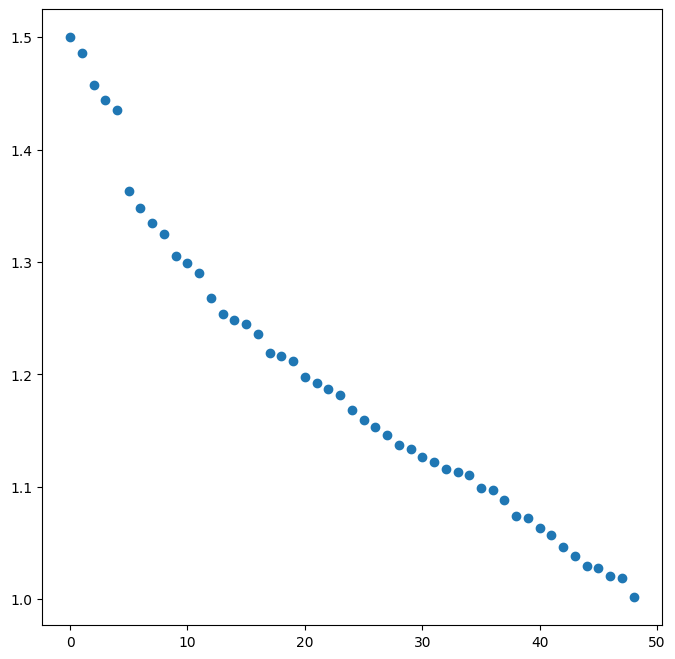

In [16]:
x_ax = np.arange(Lap.shape[0])
plt.scatter(x_ax, sorted_evals)

In [19]:
hnx_clusters = hnx.algorithms.laplacians_clustering.spec_clus(HG, k=5, weights=True)
hnx_clusters

{0: ['HMGA1',
  'RBPJ',
  'GATA6',
  'FOXH1',
  'ID3',
  'TCF15',
  'TFCP2L1',
  'FOXD3',
  'ELF3',
  'SNAI1',
  'SOX7',
  'MSC',
  'KLF2',
  'POU5F1',
  'TFEB',
  'DNMT3L',
  'SALL4',
  'DNMT3A',
  'RUNX1',
  'EPAS1',
  'TBX3',
  'BHLHE40',
  'MYBL2',
  'SOX2',
  'BMYC'],
 1: ['FOXQ1',
  'NFXL1',
  'RERE',
  'NFIL3',
  'CREB3',
  'CREB3L2',
  'HNF1B',
  'HOPX',
  'PURB',
  'BMP2'],
 2: ['TRP53', 'TEAD4', 'KDM5B', 'NANOG', 'ERF', 'ZFP42'],
 3: ['SIX1', 'GATA4', 'ELF2', 'PHB', 'SOX17'],
 4: ['KLF3', 'HNRNPK', 'ZBTB10']}